In [1]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
from IPython.display import VimeoVideo
from pymongo import MongoClient
from sklearn.metrics import mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from glob import glob
warnings.simplefilter(action="ignore", category=FutureWarning)

In [9]:
#this is if we are dealing with mango db, but we are no
Client =MongoClient(host="Localhost",port=27017)
db =Client["air-quality"]
nairobi = db["nairobi"]

In [4]:
#THIS IS IF WE ARE STILL DEALING WITH MANGODB BUT WE ARE NOT



#def wrangle(collection):
    #results = collection.find(
        #{"metadata.site": 29, "metadata.measurement": "P2"},
        #projection={"P2": 1, "timestamp": 1, "_id": 0},
    #)

    # Read data into DataFrame
    #df = pd.DataFrame(list(results)).set_index("timestamp")

    #bring in the wrangle function
#df = wrangle(nairobi)
#df.head(10)
#print(df.shape)
    

In [5]:
#LET ME GO TO MY CODE NOW

In [2]:
def wrangle(filepath):
    
    #Read CSV file and set index as timestamp
    df=pd.read_csv(filepath)
    
    # convert the timestamp column to datetime
    df["timestamp"] = pd.to_datetime(df['timestamp'])
    
    # use that column as an index for the whole df;
    df.set_index('timestamp',drop=False, inplace=True)
    
    df.index = pd.DatetimeIndex(df.index).to_period('H') #this is use to convert time stamp to hrs
    
    # when i tried localizing the timezone to UTC, it said timezone aware, so i just converted to Africa?Nairobi straight
    #df.index  = df.index.tz_localize("UTC").tz_convert('Africa/Nairobi')
    
    df.drop(columns=["sensor_id","sensor_type","location","lat","lon",],inplace=True)
    
    #we need p2 only
    mask = df["value_type"]=="P2"
    df=df[mask]
    
    #remove outliers
    df=df[df["value"]<200]
    
    df.drop(columns=["value_type"],inplace=True)
    
    
    #Resampling the time series, filling for missing values and converting  to series 
    
    df=df["value"].resample("1H").mean().fillna(method="ffill")#.to_frame()
    
    #i am dropping value type because its a string and it wont work for calculation and i aslo dont need it for prediction
    return df

In [3]:
df =wrangle('C:\\Users\\User\\project three air quality in nairobi\\nairobi air quality sep 2023.csv.csv')
df.info()
df.head(20)

<class 'pandas.core.series.Series'>
PeriodIndex: 638 entries, 2023-09-01 00:00 to 2023-09-27 13:00
Freq: H
Series name: value
Non-Null Count  Dtype  
--------------  -----  
638 non-null    float64
dtypes: float64(1)
memory usage: 10.0 KB


C:\Users\User\AppData\Local\Temp\ipykernel_5624\3164358970.py:12: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df.index = pd.DatetimeIndex(df.index).to_period('H') #this is use to convert time stamp to hrs


timestamp
2023-09-01 00:00    16.196042
2023-09-01 01:00    17.610897
2023-09-01 02:00    19.618784
2023-09-01 03:00    25.764591
2023-09-01 04:00    22.218325
2023-09-01 05:00    26.616510
2023-09-01 06:00    23.063641
2023-09-01 07:00    20.820104
2023-09-01 08:00    22.194286
2023-09-01 09:00    18.960081
2023-09-01 10:00    19.769920
2023-09-01 11:00    25.657061
2023-09-01 12:00    26.035633
2023-09-01 13:00    27.623454
2023-09-01 14:00    29.706790
2023-09-01 15:00    30.453696
2023-09-01 16:00    26.806326
2023-09-01 17:00    26.646906
2023-09-01 18:00    23.060221
2023-09-01 19:00    18.923750
Freq: H, Name: value, dtype: float64

In [4]:
print(df.shape)
df.head(20)

(638,)


timestamp
2023-09-01 00:00    16.196042
2023-09-01 01:00    17.610897
2023-09-01 02:00    19.618784
2023-09-01 03:00    25.764591
2023-09-01 04:00    22.218325
2023-09-01 05:00    26.616510
2023-09-01 06:00    23.063641
2023-09-01 07:00    20.820104
2023-09-01 08:00    22.194286
2023-09-01 09:00    18.960081
2023-09-01 10:00    19.769920
2023-09-01 11:00    25.657061
2023-09-01 12:00    26.035633
2023-09-01 13:00    27.623454
2023-09-01 14:00    29.706790
2023-09-01 15:00    30.453696
2023-09-01 16:00    26.806326
2023-09-01 17:00    26.646906
2023-09-01 18:00    23.060221
2023-09-01 19:00    18.923750
Freq: H, Name: value, dtype: float64

In [5]:
df.corr(df.shift(2))

0.6819955530494248

In [19]:
#the question now is how many lag should we have in our in other to have good predictive power. what of 2 h, 3h lag will it give us good correlating power?
#by using lag we are going backward to predict whah happened in the future.
e.g
#y.corr(y) we are saying what happen now does it correlate with waht is happening now? answer will be 1
#y.corr(y.shift(1)) meaning what happen now does it correlate with what happens 1h ago?

0    timestamp
dtype: object

In [11]:
df.corr(df)


1.0

In [6]:
df.corr(df.shift(3))


#the more we go backward the poor correlation we have

0.5228991070800326

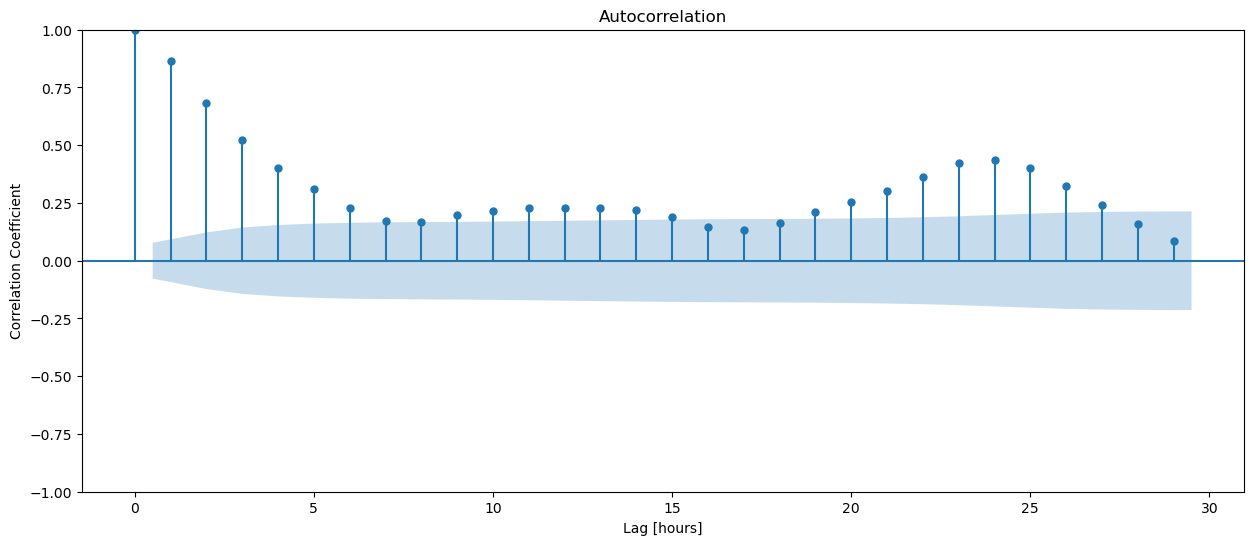

In [7]:
#let make a visualization of it
fig, ax = plt.subplots(figsize=(15, 6))
plot_acf(df,ax=ax)
plt.xlabel("Lag [hours]")
plt.ylabel("Correlation Coefficient");


# Anything within the blue path is statistically not significant, we are only interested in value above or below it
# the correlating power almost thesame except for point 0
# acf help us to determine how correlation changes with lag but cannot help us to determine the number of lag to use
# from left to right we move further into the past on x axis wher the predicting power is low
# from bottom up correlation get stonger on y axis
# y axis, 1= strong correlation coefficient and 0 no correlation

In [69]:

#df.value.shift(1).corr(df.value.shift(3))

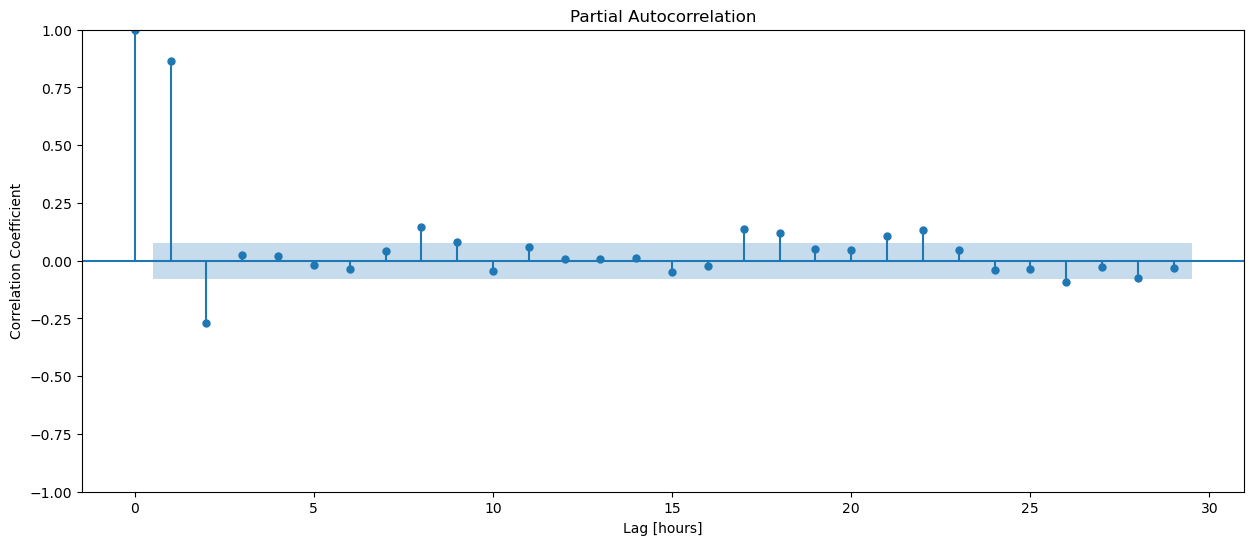

In [8]:
#explore

fig, ax = plt.subplots(figsize=(15, 6))
plot_pacf(df,ax=ax)
plt.xlabel("Lag [hours]")
plt.ylabel("Correlation Coefficient");

#pacf help us to determine which lag has the highest correlating power
# generally speaking our predictive power stop at 22 beyond that we have no predictive power. we relly dont want to go beyond 23

In [9]:
df.tail(20).isnull()

timestamp
2023-09-26 18:00    False
2023-09-26 19:00    False
2023-09-26 20:00    False
2023-09-26 21:00    False
2023-09-26 22:00    False
2023-09-26 23:00    False
2023-09-27 00:00    False
2023-09-27 01:00    False
2023-09-27 02:00    False
2023-09-27 03:00    False
2023-09-27 04:00    False
2023-09-27 05:00    False
2023-09-27 06:00    False
2023-09-27 07:00    False
2023-09-27 08:00    False
2023-09-27 09:00    False
2023-09-27 10:00    False
2023-09-27 11:00    False
2023-09-27 12:00    False
2023-09-27 13:00    False
Freq: H, Name: value, dtype: bool

In [10]:
#split now
#Split y into training and test sets. The first 95% of the data should be in your training set. The remaining 5% should be in the test set. 5% just for the sake of speediness if its more than that our walk forward validation wiil be slow
cutoff_test= int(len(df)*0.95)
df_train =df.iloc[:cutoff_test]
df_test =df.iloc[cutoff_test:]


In [11]:
#len(y_train)
#len(y_test)
#len(y)

#len(df_train)+len(df_test)
#len(df_train)+len(df_test)==len(df)

True

In [12]:
#Build Model
#Baseline
#Calculate the baseline mean absolute error for your model.

df_train_mean = df_train.mean()
df_pred_baseline = [df_train_mean] * len(df_train)
mae_baseline = mean_absolute_error(df_train, df_pred_baseline)

print("p2 reading:", round(df_train_mean, 2))
print("Baseline MAE:", round(mae_baseline, 2))

p2 reading: 22.55
Baseline MAE: 6.65


In [96]:
#df= pd.Series(df)
#df
#df.index.to_timestamp()
#df.index = pd.DatetimeIndex(df.index).to_period('M')

In [52]:



#Instantiate an AutoReg model and fit it to the training data y_train. Be sure to set the lags argument to 10
model = AutoReg(df_train, lags=23).fit()

#df
#regressor.fit(x[:, None], y)

In [53]:
model.predict()

timestamp
2023-09-01 00:00          NaN
2023-09-01 01:00          NaN
2023-09-01 02:00          NaN
2023-09-01 03:00          NaN
2023-09-01 04:00          NaN
                      ...    
2023-09-26 01:00    21.247526
2023-09-26 02:00    23.622425
2023-09-26 03:00    17.419457
2023-09-26 04:00    24.912374
2023-09-26 05:00    23.472437
Freq: H, Length: 606, dtype: float64

In [16]:
#Generate a list of training predictions for your model and use them to calculate your training mean absolute error.
model.predict().isnull().sum()


23

In [54]:
#mea absolute error is a performance matrix use to generate how our model is performing with training data


df_pred =model.predict().dropna()
training_mae = mean_absolute_error(df_train.iloc[23:],df_pred)
print("Training MAE:", training_mae)

Training MAE: 2.9426811075053534


In [55]:
#Task 3.3.10: Use y_train and y_pred to calculate the residuals for your model.
#we have been overlooking it before but we need to add it now
#y_train_resid = y_train - y_pred or
df_train_resid =model.resid 
df_train_resid.tail()

#residual is the difference between actual value and predictive value

#in MAE we have, y( real) - y( predict)/ divide by n. n = number of sample, but we are suppsed to find 
#resiual first before MAE ( we have been neglecting that thou) which y( real) - y( predict)
#we want to make sure they our residaul is well distributed( bell shaped)

timestamp
2023-09-26 01:00    2.006539
2023-09-26 02:00   -6.123610
2023-09-26 03:00    6.466856
2023-09-26 04:00   -1.012123
2023-09-26 05:00   -2.846664
Freq: H, dtype: float64

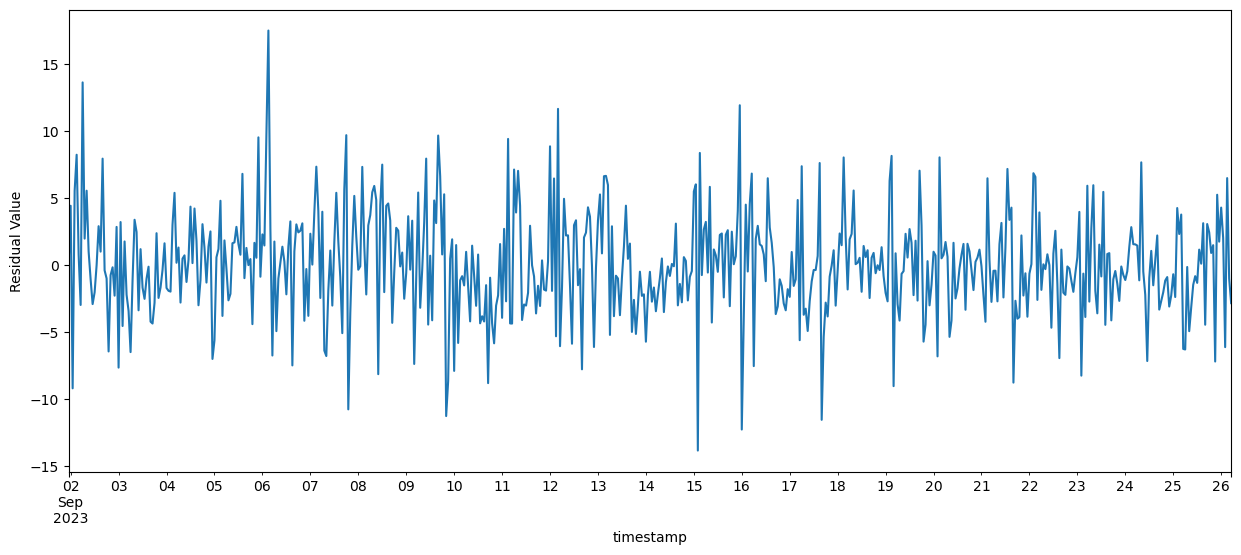

In [56]:
#Task 3.3.11: Create a plot of y_train_resid.
#we plot time series plot for residual and also histogram

#time seies plot
fig, ax = plt.subplots(figsize=(15, 6))
df_train_resid.plot(ylabel="Residual Value", ax=ax);

#we plot this in order to know if they are normally distributed or not

#The value above 0 shows where we underestimate our true value while value below 0 shows where we overrestimate the true value.
#we need value around zero so as to be sure that our residul will  be normally distributed  but from the graph below it is not.

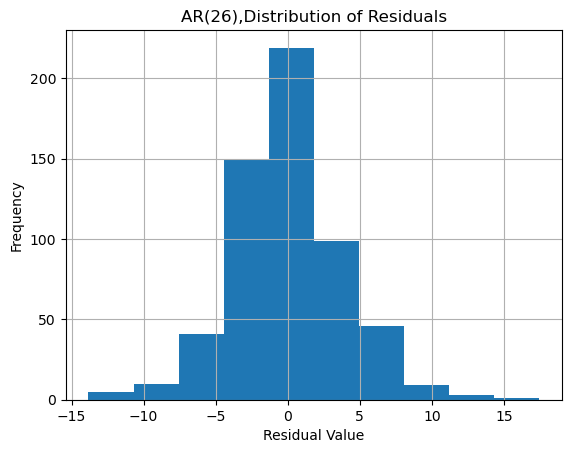

In [57]:
#Task 3.3.12: Create a histogram of y_train_resid.


df_train_resid.hist()
plt.xlabel("Residual Value")
plt.ylabel("Frequency")
plt.title("AR(26),Distribution of Residuals");


#good its normally distributed we are good to go

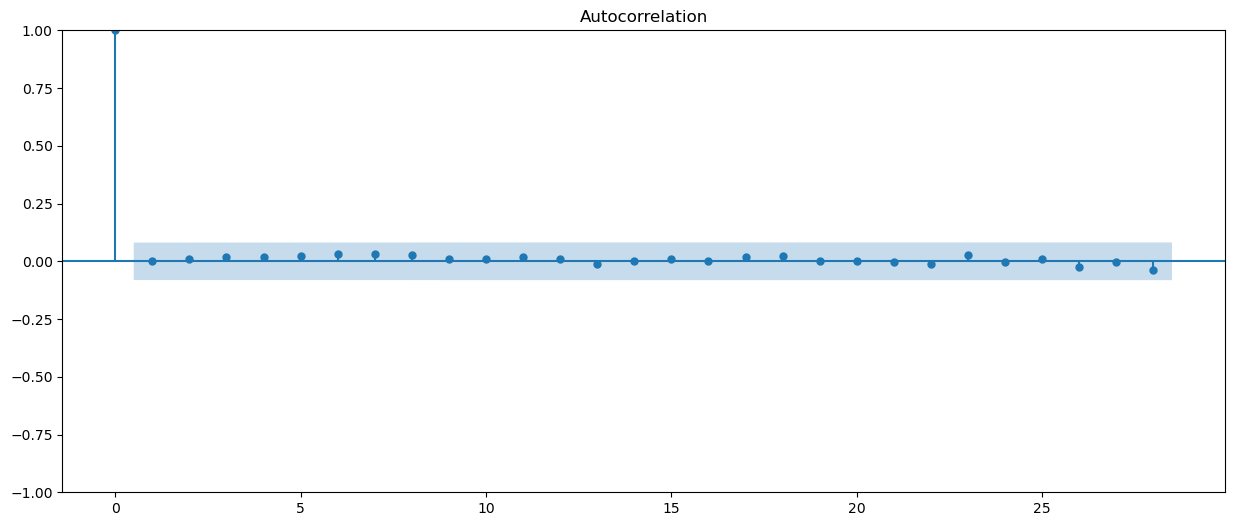

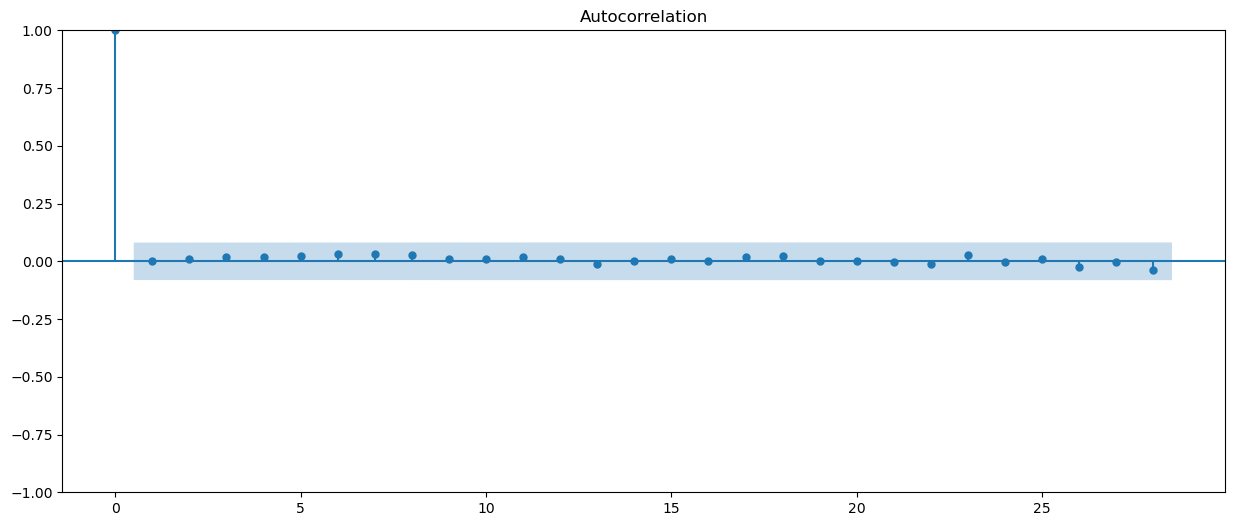

In [58]:
#Task 3.3.13: Create an ACF plot of y_train_resid.

fig, ax = plt.subplots(figsize=(15, 6))
plot_acf(df_train_resid, ax=ax)


In [38]:
#you see that from the above there is no more signal left in our residue, our model has pull out those signals( predictive power) during training. this is good.

In [42]:
#now let see if our model can generalise, we want to see waht our performance matrix are(MEA) ON OUR TEST DATA
df.index.min()

Period('2023-09-01 00:00', 'H')

In [59]:
df_test

timestamp
2023-09-26 06:00    25.110141
2023-09-26 07:00    28.975313
2023-09-26 08:00    35.672240
2023-09-26 09:00    33.576624
2023-09-26 10:00    23.260422
2023-09-26 11:00    15.909178
2023-09-26 12:00    17.521554
2023-09-26 13:00    28.794935
2023-09-26 14:00    31.337966
2023-09-26 15:00    22.431538
2023-09-26 16:00    18.829795
2023-09-26 17:00    32.614260
2023-09-26 18:00    35.723851
2023-09-26 19:00    26.146626
2023-09-26 20:00    16.697090
2023-09-26 21:00    12.101337
2023-09-26 22:00    11.160683
2023-09-26 23:00    12.483836
2023-09-27 00:00    13.563165
2023-09-27 01:00    18.265405
2023-09-27 02:00    23.425708
2023-09-27 03:00    28.221000
2023-09-27 04:00    30.422818
2023-09-27 05:00    28.174135
2023-09-27 06:00    27.518182
2023-09-27 07:00    30.029780
2023-09-27 08:00    26.765276
2023-09-27 09:00    21.092674
2023-09-27 10:00    19.342789
2023-09-27 11:00    15.853291
2023-09-27 12:00    15.753304
2023-09-27 13:00    19.045870
Freq: H, Name: value, dtype: f

In [60]:
#Task 3.3.14: Calculate the test mean absolute error for your model. to see if our model can generalise
df_pred_test = model.predict(df_test.index.min(), df_test.index.max()) #( the first and last obsevation in my test set that is we are using min and max. if i didnt do min and max it will just do prediction for training data and we dont want that
test_mae =mean_absolute_error(df_test, df_pred_test)
print("Test MAE:", test_mae)


#our test performance is   not good compare to our train perfomnce and basline
#Training MAE: 2.9426811075053534
#Baseline MAE: 6.65
#Test MAE: 7.31903230460302
#let plot it out to see what happen


#traditional testing does not work with time series the way to do it is to do walk forward validation

Test MAE: 7.31903230460302


In [61]:

#Task 3.3.15: Create a DataFrame test_predictions that has two columns: "y_test" and "y_pred". The first should contain the true values for your test set, and the second should contain your model's predictions. Be sure the index of test_predictions matches the index of y_test


df_pred_test = pd.DataFrame(
    {"df_test": df_test, "df_pred": df_pred_test}, index=df_test.index
)
df_pred_test

#dictionary showing our test and prediction

,df_test,df_pred
timestamp,,
2023-09-26 06:00,25.110141,17.871201
2023-09-26 07:00,28.975313,15.671336
2023-09-26 08:00,35.672240,14.239992
2023-09-26 09:00,33.576624,14.897420
2023-09-26 10:00,23.260422,14.732112
2023-09-26 11:00,15.909178,13.157898
2023-09-26 12:00,17.521554,13.656879
2023-09-26 13:00,28.794935,15.910152
2023-09-26 14:00,31.337966,18.227151


In [46]:
fig = px.line(df_pred_test,labels={"value":"P2"})
#fig.show()
#let plot our predict 
#you see our plot dies off with time
# VERY IMPORTANTLY traditional testing does not work with time series DATA,  the way to do it is to do walk forward validation

In [66]:
%%capture
df_pred_wfv = pd.Series()
history = df_train.copy()
for i in range(len(df_test)):
    model=AutoReg(history, lags=26).fit()
    next_pred=model.forecast()
    df_pred_wfv=df_pred_wfv.append(next_pred)
    history=history.append(df_test[next_pred.index])
    pass
 #Task 3.3.17: Perform walk-forward validation for your model for the entire test set y_test. Store your model's predictions in the Series y_pred_wfv.   

In [67]:
test_mae = mean_absolute_error(df_test, df_pred_wfv)
print("Test MAE (walk forward validation):", round(test_mae, 2))

# we see now that our model will genegralized well

Test MAE (walk forward validation): 3.68


In [68]:
#communicate result

#Task 3.3.19: Print out the parameters for your trained model.
print(model.params)

const        1.817690
value.L1     1.050174
value.L2    -0.245356
value.L3    -0.008084
value.L4     0.013727
value.L5     0.045171
value.L6    -0.033955
value.L7    -0.072928
value.L8     0.027356
value.L9     0.105008
value.L10   -0.102179
value.L11    0.071581
value.L12   -0.004192
value.L13   -0.028183
value.L14    0.058017
value.L15    0.028676
value.L16   -0.135292
value.L17    0.019464
value.L18    0.071286
value.L19    0.010231
value.L20   -0.016403
value.L21   -0.039520
value.L22    0.092953
value.L23    0.070454
value.L24   -0.017017
value.L25    0.044951
value.L26   -0.086021
dtype: float64


In [85]:
df_pred_test=pd.DataFrame(
    {"df_test":df_test, "df_pred_wfv": df_pred_wfv}
)
fig = px.line(df_pred_test, labels={"value_type":"P2"})
fig.show()




#Task 3.3.20: Put the values for y_test and y_pred_wfv into the DataFrame df_pred_test (don't forget the index). Then plot df_pred_test using plotly express.
#Task 3.3.20: Put the values for y_test and y_pred_wfv into the DataFrame df_pred_test (don't forget the index). Then plot df_pred_test using plotly express

TypeError: Object of type Period is not JSON serializable